In [6]:
import torch
import torch.nn as nn

class SineWaveLayer(nn.Module):
    def __init__(self, n, t, phi_prev=False, w_prev=False):
        super(SineWaveLayer, self).__init__()
        self.n = n
        self.t = t
        self.phi_prev = phi_prev
        self.w_prev = w_prev
        
        # Parameters A, w, phi
        self.A = nn.Parameter(torch.randn(n, 1))
        self.w = nn.Parameter(torch.randn(n, 1))
        self.phi = nn.Parameter(torch.randn(n, 1))
        
        # Single phi_current parameter
        self.phi_current = nn.Parameter(torch.randn(1))
        
        if phi_prev:
            self.phi_previous = nn.Parameter(torch.randn(1))
        else:
            self.phi_previous = None
        
        # Single current_w parameter
        self.current_w = nn.Parameter(torch.randn(1))
        
        if w_prev:
            self.previous_w = nn.Parameter(torch.randn(1))
        else:
            self.previous_w = None

    def forward(self, t_vector, phi_previous=None, w_previous=None):
        # Expand t_vector to match the shape of parameters
        t_vector = t_vector.unsqueeze(0).expand(self.n, -1)
        
        # Calculate the phase
        phi = self.phi
        phi_static = self.phi_current
        if self.phi_prev and phi_previous is not None:
            phi_static = phi_static + phi_previous
        phi = phi + phi_static
        
        # Calculate the angular frequency
        w = self.w
        w_static = self.current_w
        if self.w_prev and w_previous is not None:
            w_static = w_static + w_previous
        w = w + w_static
        
        # Calculate the sine wave
        sine_wave = self.A * torch.sin(w * t_vector + phi)
        
        return sine_wave, phi_static , w_static

class SelectorWaveLayer(nn.Module):
    def __init__(self, n, m, t, phi_prev=False, w_prev=False):
        super(SelectorWaveLayer, self).__init__()
        self.n = n
        self.m = m
        self.t = t
        self.phi_prev = phi_prev
        self.w_prev = w_prev
        
        # Parameters w, phi
        self.w = nn.Parameter(torch.randn(m, n))
        self.phi = nn.Parameter(torch.randn(m, n))
        
        # Single phi_current parameter
        self.phi_current = nn.Parameter(torch.randn(1))
        
        if phi_prev:
            self.phi_previous = nn.Parameter(torch.randn(1))
        else:
            self.phi_previous = None
        
        # Single current_w parameter
        self.current_w = nn.Parameter(torch.randn(1))
        
        if w_prev:
            self.previous_w = nn.Parameter(torch.randn(1))
        else:
            self.previous_w = None

    def forward(self, t_vector, wave_input, phi_previous=None, w_previous=None):
        # Expand t_vector to match the shape of parameters
        t_vector = t_vector.unsqueeze(0).expand(self.n, -1)
        
        phi = self.phi
        phi_static = self.phi_current
        if self.phi_prev and phi_previous is not None:
            phi_static = phi_static + phi_previous
        phi = (phi + phi_static).unsqueeze(-1)
        
        # Calculate the angular frequency
        w = self.w
        w_static = self.current_w
        if self.w_prev and w_previous is not None:
            w_static = w_static + w_previous
        w = (w + w_static).unsqueeze(-1)
        
        # Calculate the sine wave
        sine_wave = 0.5 * torch.sin(w * t_vector + phi) + 0.5
        
        # Perform the weighted sum
        result = torch.einsum('ijk,jk->ik', sine_wave, wave_input)
        
        return result, phi_static, w_static

class SineWaveNetwork(nn.Module):
    def __init__(self, t):
        super(SineWaveNetwork, self).__init__()
        self.t = t
        self.t_vector = torch.linspace(1, 1000, t)
        
        # Layers
        self.sine_layer = SineWaveLayer(n=20, t=t)
        
        # Selector layers with increasing m
        self.selector_layer1 = SelectorWaveLayer(n=20, m=25, t=t)
        self.selector_layer2 = SelectorWaveLayer(n=25, m=30, t=t)
        self.selector_layer3 = SelectorWaveLayer(n=30, m=1, t=t)

    def forward(self, initial_wave_input, initial_phi=None, initial_w=None):
        # First layer
        sine_output, phi, w = self.sine_layer(self.t_vector, initial_phi, initial_w)
        
        # Selector layers
        selector_output1, phi, w = self.selector_layer1(self.t_vector, sine_output, phi, w)
        selector_output2, phi, w = self.selector_layer2(self.t_vector, selector_output1, phi, w)
        selector_output3, phi, w = self.selector_layer3(self.t_vector, selector_output2, phi, w)
        
        return selector_output3



In [12]:
# Example usage
t = 10000  # Number of time steps

# Create the network
network = SineWaveNetwork(t)

# Initial input wave (random example)
initial_wave_input = torch.randn(20, 1)

# Initial phi and w (if needed)
initial_phi = None
initial_w = torch.tensor(0.5) if network.sine_layer.w_prev else None

# Forward pass
output = network(initial_wave_input, initial_phi, initial_w)
print(output.shape)  # Should print torch.Size([20, t])


torch.Size([1, 10000])


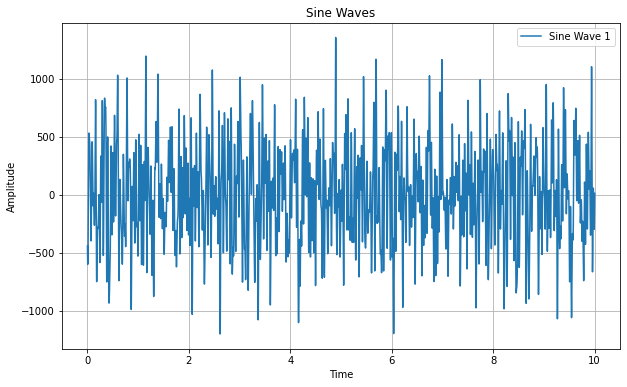

In [13]:
import matplotlib.pyplot as plt

def plot_sine_waves(waves_tensor):
    """
    Plot sine waves from a tensor of shape (n, t).

    Parameters:
    waves_tensor (torch.Tensor): Tensor of shape (n, t) containing the sine waves.
    """
    n, t = waves_tensor.shape
    t_values = torch.linspace(0, 10, t).numpy()
    
    plt.figure(figsize=(10, 6))
    for i in range(n):
        wave = waves_tensor[i].detach().numpy()
        plt.plot(t_values, wave, label=f'Sine Wave {i+1}')
    
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.title('Sine Waves')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot the sine waves
plot_sine_waves(output)


In [ ]:
##initialization? 
## activation functions (lots of linear things, things that shouldn't be zero....)
## learning input and  coefficient? 
